In [51]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid', {'axes.edgecolor': 'black'})

import pyrosetta
import pyrosetta.distributed.tasks.score as score
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.io as io
import pyrosetta.distributed
pyrosetta.distributed.init('-fast_restyping')
pyrosetta.distributed.maybe_init()

import logging
logging.basicConfig(level=logging.INFO)

## Prolog

The following notebook contains the functions for filtering the pdbs and calculating amino acid frequencies for the extracted proteins and also the finally designed proteins. Obviously, the pdbs are not contained in this directory due to their size. They were organised as follows:
```
├── af_models
│   ├── download_alphafold_structures.sh     # <- script to download all structures
│   ├── ecoli_alphaFold_models               # Raw AF2 predictions of all e.coli proteins
│   ├── filter_pLDDT.py                      # <- script to filter AF2 predicitons based on pLDDT
│   └── hyperthermo_alphaFold_models         # Raw AF2 predicitons of all hyperthermophilic proteins used
├── af_models_design
│   ├── ecoli_hyper                          # Designs of filtered e.coli proteins using HyperMPNN
│   ├── ecoli_mpnn                           # Designs of filtered e.coli proteins using default ProteinMPNN
│   ├── thermo_hyper                         # Designs of filtered hyperthermophilic proteins using HyperMPNN
│   └── thermo_mpnn                          # Designs of filtered hyperthermophilic proteins using default ProteinMPNN
├── af_models_filtered
│   ├── ecoli_filtered_plddt                 # Filtered AF2 predictions of e.coli
│   └── hyperthermo_filtered_plddt           # Filtered AF2 predicition of hyperthermophilic proteins
```

They would have to be recreated. However, the results of the calculations are stored in the `data` folder.

## 1. Calculate the packing metrics

The packing metrics were calculated based on the original plDDT-filtered structures for *E. coli* and the proteins for the hyperthermophilic organisms and all their designs with ProteinMPNN and HyperMPNN, respectively. Multiple metrics were calculated using Rosetta:

- Exposed hydrophobics
- Netto charge
- Packing statistics
- Lawrence and Coleman shape complementarity of secondary structure elements
- Solvent-accessible surface area (SASA)
- Radius of gyration
- Contact order

Not all of them were used in later calculation. For the sake of completeness, however, they are also listed here.

In [16]:
score_task = rosetta_scripts.SingleoutputRosettaScriptsTask("""
    <ROSETTASCRIPTS>
    <SCOREFXNS>
    <ScoreFunction name="scorefxn" weights="empty.wts" >
         <Reweight scoretype="rg" weight="1.0" />
         <Reweight scoretype="co" weight="1.0" />
    </ScoreFunction>
    </SCOREFXNS>
    <RESIDUE_SELECTORS>
        <Chain name="all" chains="1"/>
    </RESIDUE_SELECTORS>
    <TASKOPERATIONS>
    </TASKOPERATIONS>
    <FILTERS>
        <ExposedHydrophobics name="exposed_hydros" threshold="-1" />
        <NetCharge name="net_charge" min="-10000" max="10000"/>
        <PackStat name="packstat" threshold="0" repeats="3"/>
        <SSShapeComplementarity name="shape_comp" loops="true" helices="true" min_sc="0.0"/>
        <TotalSasa name="total_SASA" threshold="0"/>
    </FILTERS>
    <SIMPLE_METRICS>
        <SequenceMetric name="sequence"/>
        <SapScoreMetric name="sap"/>
        <TotalEnergyMetric name="radius_of_gyration" scoretype="rg" scorefxn="scorefxn" custom_type="RoG"/>
        <TotalEnergyMetric name="contact_order" scoretype="co" scorefxn="scorefxn" custom_type="ContactOrder"/>
    </SIMPLE_METRICS>
    <MOVERS>
        <RunSimpleMetrics name="run_metrics" metrics="sequence,sap,radius_of_gyration,contact_order"/>
    </MOVERS>
    <PROTOCOLS>
        <Add filter="exposed_hydros"/>
        <Add filter="net_charge"/>
        <Add filter="packstat"/>
        <Add filter="shape_comp"/>
        <Add filter="total_SASA"/>
        <Add mover="run_metrics"/>
    </PROTOCOLS>
    </ROSETTASCRIPTS>
    """)
score_task.setup() # check syntax


def process_pdb(pdb_file):
    """Function to process a single PDB file."""
    try:
        pose = io.pose_from_file(pdb_file)
        result = score_task(pose)
        scores_dict = result.scores
        scores_dict['file'] = pdb_file
        return scores_dict
    except Exception as e:
        print(f"Error processing {pdb_file}: {e}")
        return None


def process_pdb_files(pdb_files, n_processes=1):
    """Function to process a list of PDB files for packing statistics"""
    with pyrosetta.distributed.utility.log.LoggingContext(logging.getLogger("rosetta"), level=logging.WARN):
        with Pool(n_processes) as p:
            results = list(p.imap(process_pdb, pdb_files))
            results = [r for r in results if r is not None]
    return results


def files_for_path(path, extension='.pdb'):
    return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(extension)]

core.select.residue_selector.util: [ WARNING ] Selector name is empty!


In [66]:
# The following command were used to generate the data and only runned once,
# therefore they are commented out to avoid running them again by mistake.
# ALL Data is in the ./data folder

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# path_ecoli_filtered = '../af_models_filtered/ecoli_filtered_plddt/'
# results = pd.DataFrame(process_pdb_files(files_for_path(path_ecoli_filtered), n_processes=12))
# # pd.DataFrame(results).to_csv('data/metrics_ecoli_no_poses.csv')

# path_ecoli_mpnn_design = '../af_models_design/ecoli_mpnn/'
# results = pd.DataFrame(process_pdb_files(files_for_path(path_ecoli_mpnn_design), n_processes=12))
# # pd.DataFrame(results).to_csv('data/metrics_ecoli_mpnn_no_poses.csv')

# path_ecoli_hyper_design = '../af_models_design/ecoli_hyper/'
# results = pd.DataFrame(process_pdb_files(files_for_path(path_ecoli_hyper_design), n_processes=12))
# # pd.DataFrame(results).to_csv('data/metrics_ecoli_mpnn_tuned_no_poses.csv')

# path_thermo_filtered = '../af_models_filtered/hyperthermo_filtered_plddt/'
# results = pd.DataFrame(process_pdb_files(files_for_path(path_thermo_filtered), n_processes=12))
# # pd.DataFrame(results).to_csv('data/metrics_thermo_no_poses.csv')

# path_thermo_mpnn_design = '../af_models_design/thermo_mpnn/'
# results = pd.DataFrame(process_pdb_files(files_for_path(path_thermo_mpnn_design), n_processes=12))
# # pd.DataFrame(results).to_csv('data/metrics_thermo_mpnn_no_poses.csv')

# path_thermo_hyper_design = '../af_models_design/thermo_hyper/'
# results = pd.DataFrame(process_pdb_files(files_for_path(path_thermo_hyper_design), n_processes=12))
# # pd.DataFrame(results).to_csv('data/metrics_thermo_mpnn_tuned_no_poses.csv')

## 2. Analysis and plotting

In [38]:
metrics_ecoli = pd.read_csv('data/metrics_ecoli_no_poses.csv', index_col=0)
metrics_ecoli_mpnn = pd.read_csv('data/metrics_ecoli_mpnn_no_poses.csv', index_col=0)
metrics_ecoli_hyper = pd.read_csv('data/metrics_ecoli_mpnn_tuned_no_poses.csv', index_col=0)
metrics_thermo = pd.read_csv('data/metrics_thermo_no_poses.csv', index_col=0)
# metrics_thermo_mpnn = pd.read_csv('data/metrics_thermo_mpnn_no_poses.csv', index_col=0)
# metrics_thermo_hyper = pd.read_csv('data/metrics_thermo_mpnn_tuned_no_poses.csv', index_col=0)

In [37]:
# Add some labels for later
metrics_ecoli['source'] = 'E. coli'
metrics_ecoli_mpnn['source'] = 'E. coli\nProteinMPNN\ndesigns'
metrics_ecoli_hyper['source'] = 'E. coli\nHyperMPNN\ndesigns'
metrics_thermo['source'] = 'Hyperthermophiles'

combined_df = pd.concat([metrics_ecoli, metrics_thermo, metrics_ecoli_mpnn, metrics_ecoli_hyper])
df_orga = pd.concat([metrics_ecoli, metrics_thermo])

# Boxplot probs
BOXPROBS = dict(
    boxprops=dict(edgecolor='k', alpha=0.85, linewidth=2),
    whiskerprops=dict(color='k', linewidth=2),
    capprops=dict(color='k', linewidth=2),
    medianprops=dict(color='k', linewidth=2),
    flierprops=dict(marker='o', markersize=5, color='k'),
)

# Color scheme
colors = ['#1E9CCE','#FF0000','#51698A','#B43445']

### Contact order

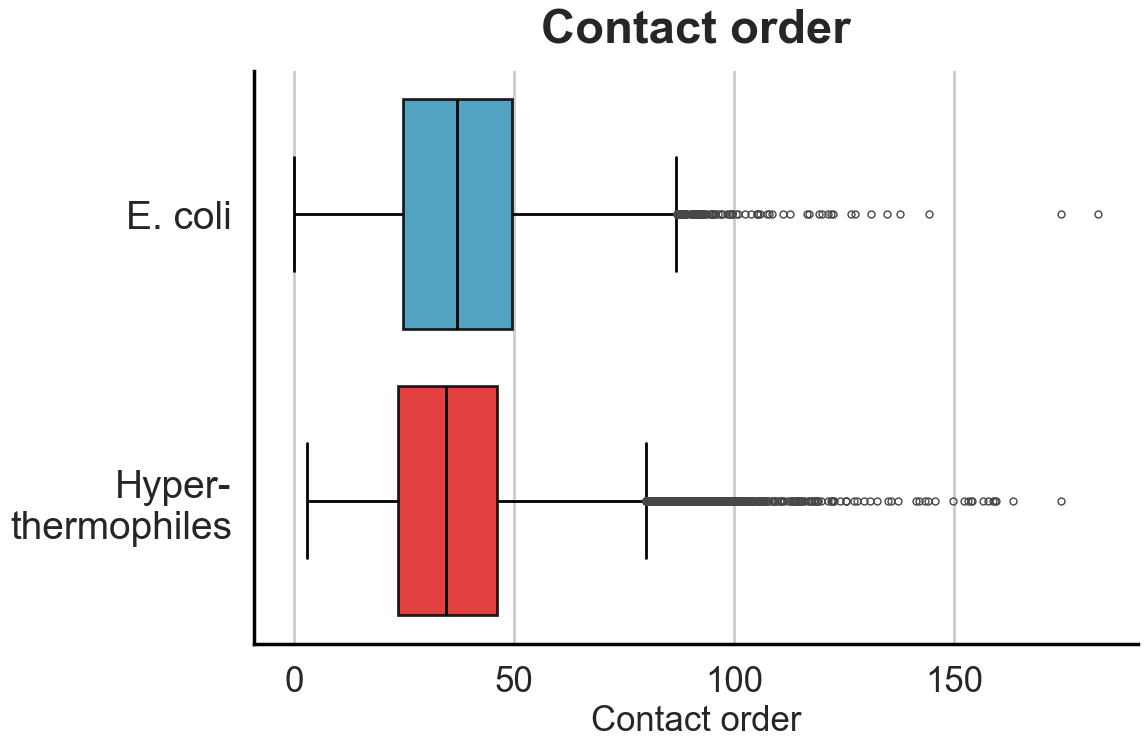

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
boxplot = sns.boxplot(x='ContactOrder_total_energy', y='source', hue='source', data=df_orga, 
                      palette=colors[:2], ax=ax, **BOXPROBS)

ax.set_xticks([0, 50, 100, 150])
ax.set_xticklabels(ax.get_xticklabels(), size=25)
ax.set_yticks([0, 1])
ax.set_yticklabels(['E. coli', 'Hyper-\nthermophiles'], size=28)
ax.set_xlabel('Contact order', fontsize=25)
ax.set_ylabel('')
ax.set_title('Contact order', fontsize=34, fontweight='bold', pad=20)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('pic/plot_contact_order_only_orga.svg', dpi=400)

### Charge distribution

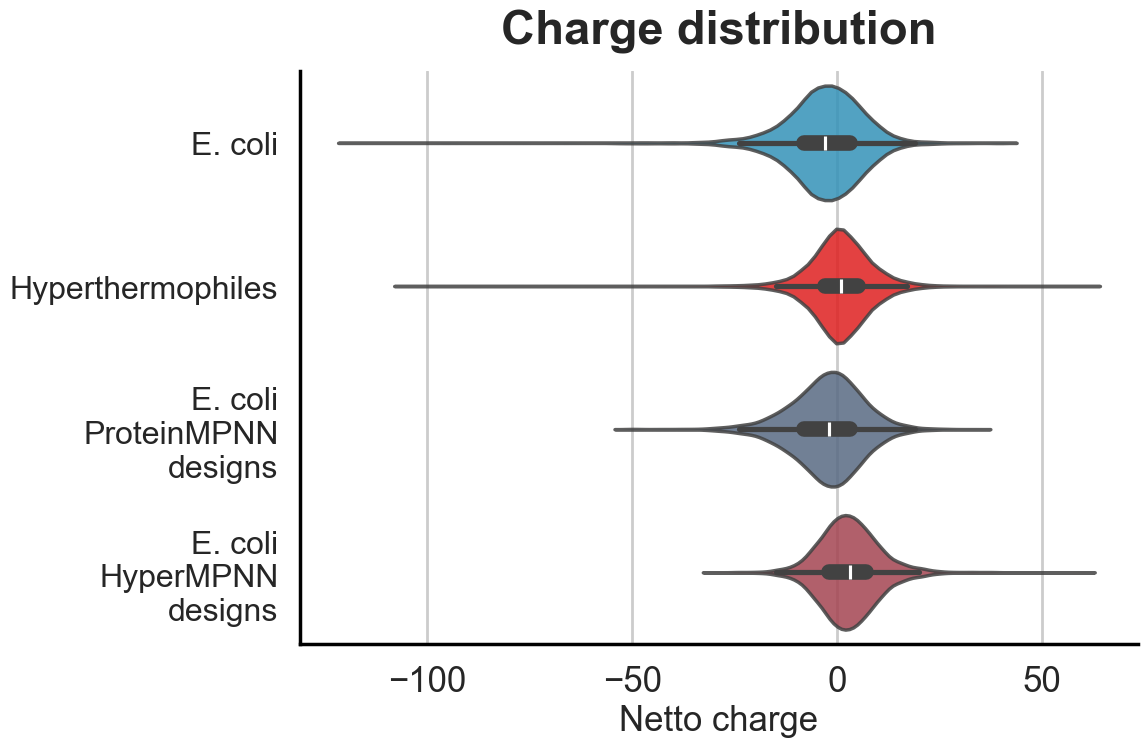

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
violin = sns.violinplot(x='net_charge', y='source', hue='source', data=combined_df, inner='box',
                        palette=colors, ax=ax, alpha=0.85)

# ax.set_xlim(0, 50)
ax.set_xticks([-100, -50, 0, 50])
ax.set_xticklabels(ax.get_xticklabels(), size=25)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(ax.get_yticklabels(), size=23)
ax.set_xlabel('Netto charge', fontsize=25)
ax.set_ylabel('')

ax.set_title('Charge distribution', fontsize=34, fontweight='bold', pad=20)
sns.despine(top=True, right=True)
plt.tight_layout()

# plt.setp(ax.collections, alpha=0.85)
plt.savefig('pic/plot_net_charge_violin.svg', dpi=400)

### Radius or gyration

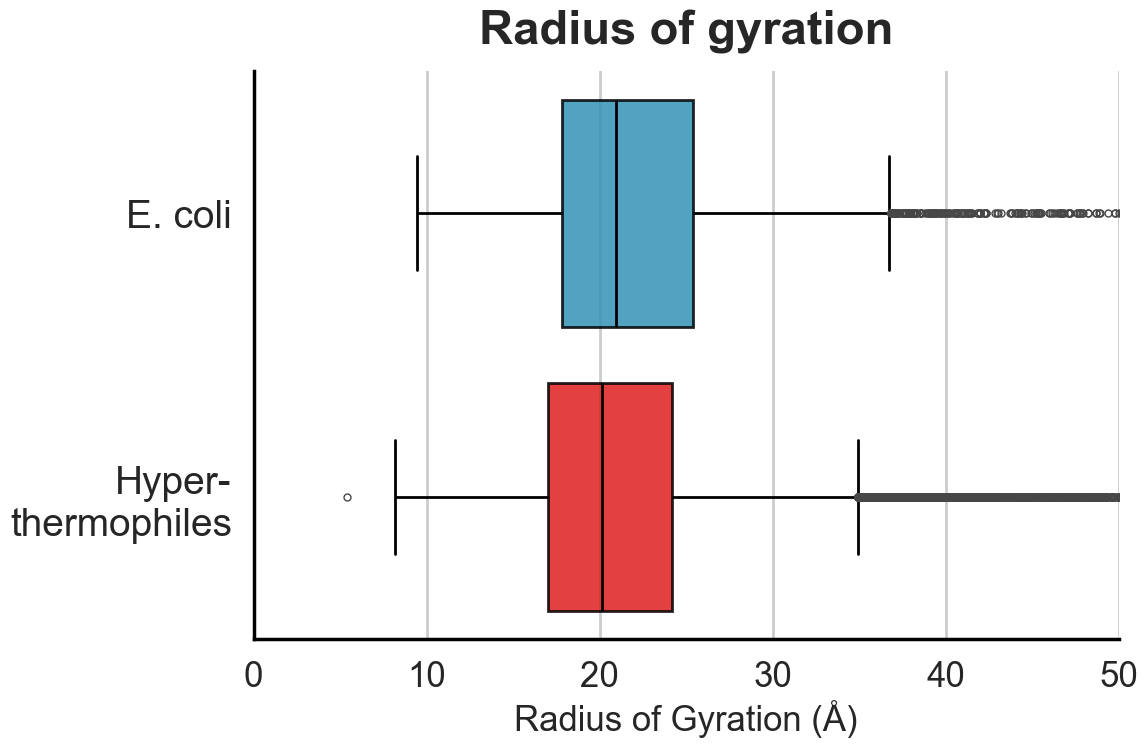

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
boxplot = sns.boxplot(x='RoG_total_energy', y='source', hue='source', data=df_orga, 
                      palette=colors[:2], ax=ax, **BOXPROBS)

ax.set_xlim(0, 50)
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(ax.get_xticklabels(), size=25)
ax.set_yticks([0, 1])
ax.set_yticklabels(['E. coli', 'Hyper-\nthermophiles'], size=28)
ax.set_xlabel('Radius of Gyration (Å)', fontsize=25)
ax.set_ylabel('')
ax.set_title('Radius of gyration', fontsize=34, fontweight='bold', pad=20)
sns.despine(top=True, right=True)
plt.tight_layout()

plt.savefig('pic/plot_gyration_only_orga.svg', dpi=400)

## 3. Calculation of salt bridges

We also want to calculate the different distributions of salt bridges for the filtered *E. coli* structures and the proteins from hyperthermophilic organisms. The designs of the complete *E. coli* proteins with ProteinMPNN and HyperMPNN will also be considered.

For the calculation we will use Rosetta.

In [56]:
from concurrent.futures import ProcessPoolExecutor
from typing import Tuple, Optional

# Salt bridge calculator from PyRosetta
sb_calculator = pyrosetta.rosetta.protocols.pose_metric_calculators.SaltBridgeCalculator()
try:
    pyrosetta.rosetta.core.pose.metrics.CalculatorFactory.Instance().register_calculator('sb_metric', sb_calculator)
except RuntimeError:
    print('Calculator already registered...')
    
def process_pdb_file(pdb_file: str) -> Optional[Tuple[str, int]]:
    if '.pdb' not in pdb_file:
        return None
    pose = pyrosetta.pose_from_pdb(pdb_file)
    sb = int(pose.print_metric('sb_metric', 'salt_bridge'))
    return (pdb_file, sb)
   
        
def process_file_wrapper(pdb_file):
    return process_pdb_file(pdb_file)
   
        
def calculate_salt(pdb_files: list[str], n_cores: int) -> list[str]:
    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        # Map the process_file_wrapper function to each pdb file
        results = list(tqdm(executor.map(process_file_wrapper, pdb_files), total=len(pdb_files)))

    filtered_results = [result for result in results if result is not None]
    return filtered_results

Error: [ ERROR ] Cannot register a calculator with name: sb_metric
Error: [ ERROR ] This calculator already exists
Calculator already registered



ERROR:: Exit from: /home/benchmark/rosetta/source/src/core/pose/metrics/CalculatorFactory.cc line: 44


In [67]:
# The following command were used to generate the data and only runned once,
# therefore they are commented out to avoid running them again by mistake.
# ALL Data is in the ./data folder
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
cols = ['PDB_file', 'Salt_Bridge_Count']

# path_ecoli_filtered = '../af_models_filtered/ecoli_filtered_plddt/'
# result = calculate_salt(files_for_path(path_ecoli_filtered), n_cores=12)
# # pd.DataFrame(result, columns=cols).to_csv('data/salt_bridges_ecoli.csv')

# path_thermo_filtered = '../af_models_filtered/hyperthermo_filtered_plddt/'
# result = calculate_salt(files_for_path(path_thermo_filtered), n_cores=12)
# # pd.DataFrame(result, columns=cols).to_csv('data/salt_bridges_thermo.csv')

# path_ecoli_mpnn = '../af_models_design/ecoli_mpnn/'
# result = calculate_salt(files_for_path(path_ecoli_mpnn), n_cores=12)
# # pd.DataFrame(result, columns=cols).to_csv('data/salt_bridges_ecoli_mpnn.csv')

# path_ecoli_hyper = '../af_models_design/ecoli_hyper/'
# result = calculate_salt(files_for_path(path_ecoli_hyper), n_cores=12)
# # pd.DataFrame(result, columns=cols).to_csv('data/salt_bridges_ecoli_hyper.csv')

### Analysis and plotting

In [68]:
metrics_ecoli_salt = pd.read_csv('data/salt_bridges_ecoli.csv', index_col=[0])
metrics_thermo_salt = pd.read_csv('data/salt_bridges_thermo.csv', index_col=[0])
metrics_ecoli_mpnn_salt = pd.read_csv('data/salt_bridges_ecoli_mpnn.csv', index_col=[0])
metrics_ecoli_mpnn_tuned_salt = pd.read_csv('data/salt_bridges_ecoli_mpnn_tuned.csv', index_col=[0])

In [70]:
# Add some labels for later and combine
metrics_ecoli_salt['source'] = 'E. coli'
metrics_thermo_salt['source'] = 'Hyperthermophiles'
metrics_ecoli_mpnn_salt['source'] = 'E. coli\nProteinMPNN\ndesigns'
metrics_ecoli_mpnn_tuned_salt['source'] = 'E. coli\nHyperMPNN\ndesigns'
combined_df_salt = pd.concat([metrics_ecoli_salt, metrics_thermo_salt, metrics_ecoli_mpnn_salt, 
                              metrics_ecoli_mpnn_tuned_salt])

# Color scheme
colors = ['#1E9CCE','#FF0000','#51698A','#B43445']

/tmp/ipykernel_533347/2504507019.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=23)


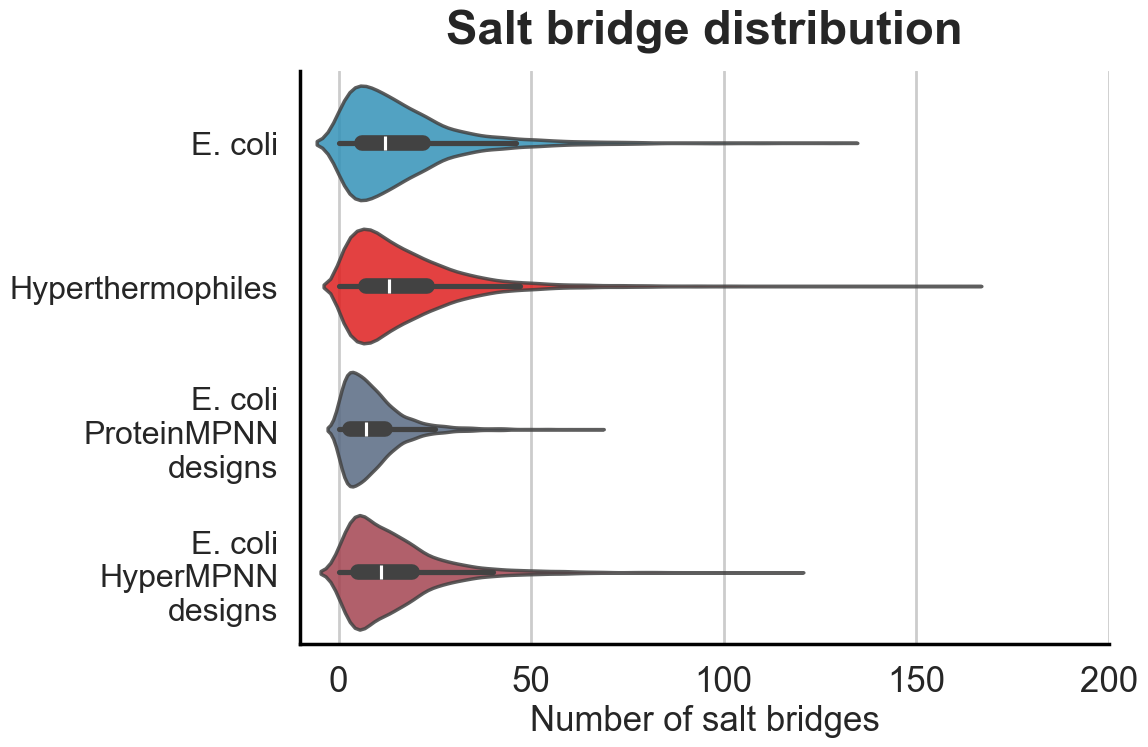

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
violin = sns.violinplot(x='Salt_Bridge_Count', y='source', hue='source', data=combined_df_salt, 
                      palette=colors, ax=ax, alpha=0.85)

ax.set_xticks([0, 50, 100, 150, 200])
ax.set_xticklabels(ax.get_xticklabels(), size=25)
ax.set_yticklabels(ax.get_yticklabels(), size=23)
ax.set_xlim(-10, 200)
ax.set_xlabel('Number of salt bridges', fontsize=25)
ax.set_ylabel('')
ax.set_title('Salt bridge distribution', fontsize=34, fontweight='bold', pad=20)
sns.despine(top=True, right=True)
plt.tight_layout()

plt.savefig('pic/plot_salt_bridges.svg', dpi=400)